Подключаем необходимые библиотеки

In [40]:
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import numpy as np

Загружаем данные (так как они находятся на google drive, то получаем таблицы оттуда, импортировав библиотеку для этого)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
test_group_data = pd. read_csv('/content/drive/My Drive/data/test_group.csv')
control_group_data = pd.read_csv('/content/drive/My Drive/data/control_group.csv')

Проверяем таблицы

In [48]:
print(test_group_data.head())
print(control_group_data.head())

   Campaign Name       Date  Spend [USD]  # of Impressions  Reach  \
0  Test Campaign  1.08.2019         3008             39550  35820   
1  Test Campaign  2.08.2019         2542            100719  91236   
2  Test Campaign  3.08.2019         2365             70263  45198   
3  Test Campaign  4.08.2019         2710             78451  25937   
4  Test Campaign  5.08.2019         2297            114295  95138   

   # of Website Clicks  # of Searches  # of View Content  # of Add to Cart  \
0                 3038           1946               1069               894   
1                 4657           2359               1548               879   
2                 7885           2572               2367              1268   
3                 4216           2216               1437               566   
4                 5863           2106                858               956   

   # of Purchase  
0            255  
1            677  
2            578  
3            340  
4            768  
  

Видим, что в контрольной группе есть NaN значения, поэтому заполняем их медианными значениями

In [26]:
control_group_data.fillna(control_group_data.median(), inplace=True)

<ipython-input-26-19801f28767f>:1: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  control_group_data.fillna(control_group_data.median(), inplace=True)


Подсчитываем метрики на основе данных и проверяем нормальности распределения. Будем использовать тест Шапиро-Уилка на данных text_group.

In [36]:
metrics = [
    'Spend [USD]',
    '# of Impressions',
    'Reach',
    '# of Website Clicks',
    '# of Searches',
    '# of View Content',
    '# of Add to Cart',
    '# of Purchase'
]

for metric in metrics:
    p_value = stats.shapiro(test_group_data[metric])[1]
    is_normal = p_value > 0.05
    print(f'{metric}: p-value = {p_value:.4f}, Нормальное распределение: {is_normal}')


Spend [USD]: p-value = 0.1171, Нормальное распределение: True
# of Impressions: p-value = 0.1537, Нормальное распределение: True
Reach: p-value = 0.0570, Нормальное распределение: True
# of Website Clicks: p-value = 0.0120, Нормальное распределение: False
# of Searches: p-value = 0.0068, Нормальное распределение: False
# of View Content: p-value = 0.0928, Нормальное распределение: True
# of Add to Cart: p-value = 0.0332, Нормальное распределение: False
# of Purchase: p-value = 0.0241, Нормальное распределение: False


Сделаем тоже самое для control_group

In [37]:
for metric in metrics:
    p_value = stats.shapiro(control_group_data[metric])[1]
    is_normal = p_value > 0.05
    print(f'{metric}: p-value = {p_value:.4f}, Нормальное распределение: {is_normal}')


Spend [USD]: p-value = 0.2313, Нормальное распределение: True
# of Impressions: p-value = 0.1012, Нормальное распределение: True
Reach: p-value = 0.6097, Нормальное распределение: True
# of Website Clicks: p-value = 0.3677, Нормальное распределение: True
# of Searches: p-value = 0.0434, Нормальное распределение: False
# of View Content: p-value = 0.0634, Нормальное распределение: True
# of Add to Cart: p-value = 0.3230, Нормальное распределение: True
# of Purchase: p-value = 0.1038, Нормальное распределение: True


Сейчас мы определим параметры для A/B групп, посмотрим на результаты и визуализируем их. Мы будем использовать t-критерий Стьюдента.

In [38]:
for metric in metrics:
    exp_group = test_group_data[metric]
    control_group = control_group_data[metric]

    t_statistic, p_value = stats.ttest_ind(exp_group, control_group)

    print(f'Метрика: {metric}')
    print(f'T-статистика: {t_statistic:.4f}')
    print(f'p-value: {p_value:.4f}')

    alpha = 0.05
    if p_value < alpha:
        print('Различия статистически значимы')
    else:
        print('Нет статистически значимых различий')
    print('\n')


Метрика: Spend [USD]
T-статистика: 2.9700
p-value: 0.0043
Различия статистически значимы


Метрика: # of Impressions
T-статистика: -4.9870
p-value: 0.0000
Различия статистически значимы


Метрика: Reach
T-статистика: -5.4059
p-value: 0.0000
Различия статистически значимы


Метрика: # of Website Clicks
T-статистика: 1.6116
p-value: 0.1125
Нет статистически значимых различий


Метрика: # of Searches
T-статистика: 1.1236
p-value: 0.2658
Нет статистически значимых различий


Метрика: # of View Content
T-статистика: -0.4920
p-value: 0.6246
Нет статистически значимых различий


Метрика: # of Add to Cart
T-статистика: -4.3360
p-value: 0.0001
Различия статистически значимы


Метрика: # of Purchase
T-статистика: -0.0164
p-value: 0.9870
Нет статистически значимых различий




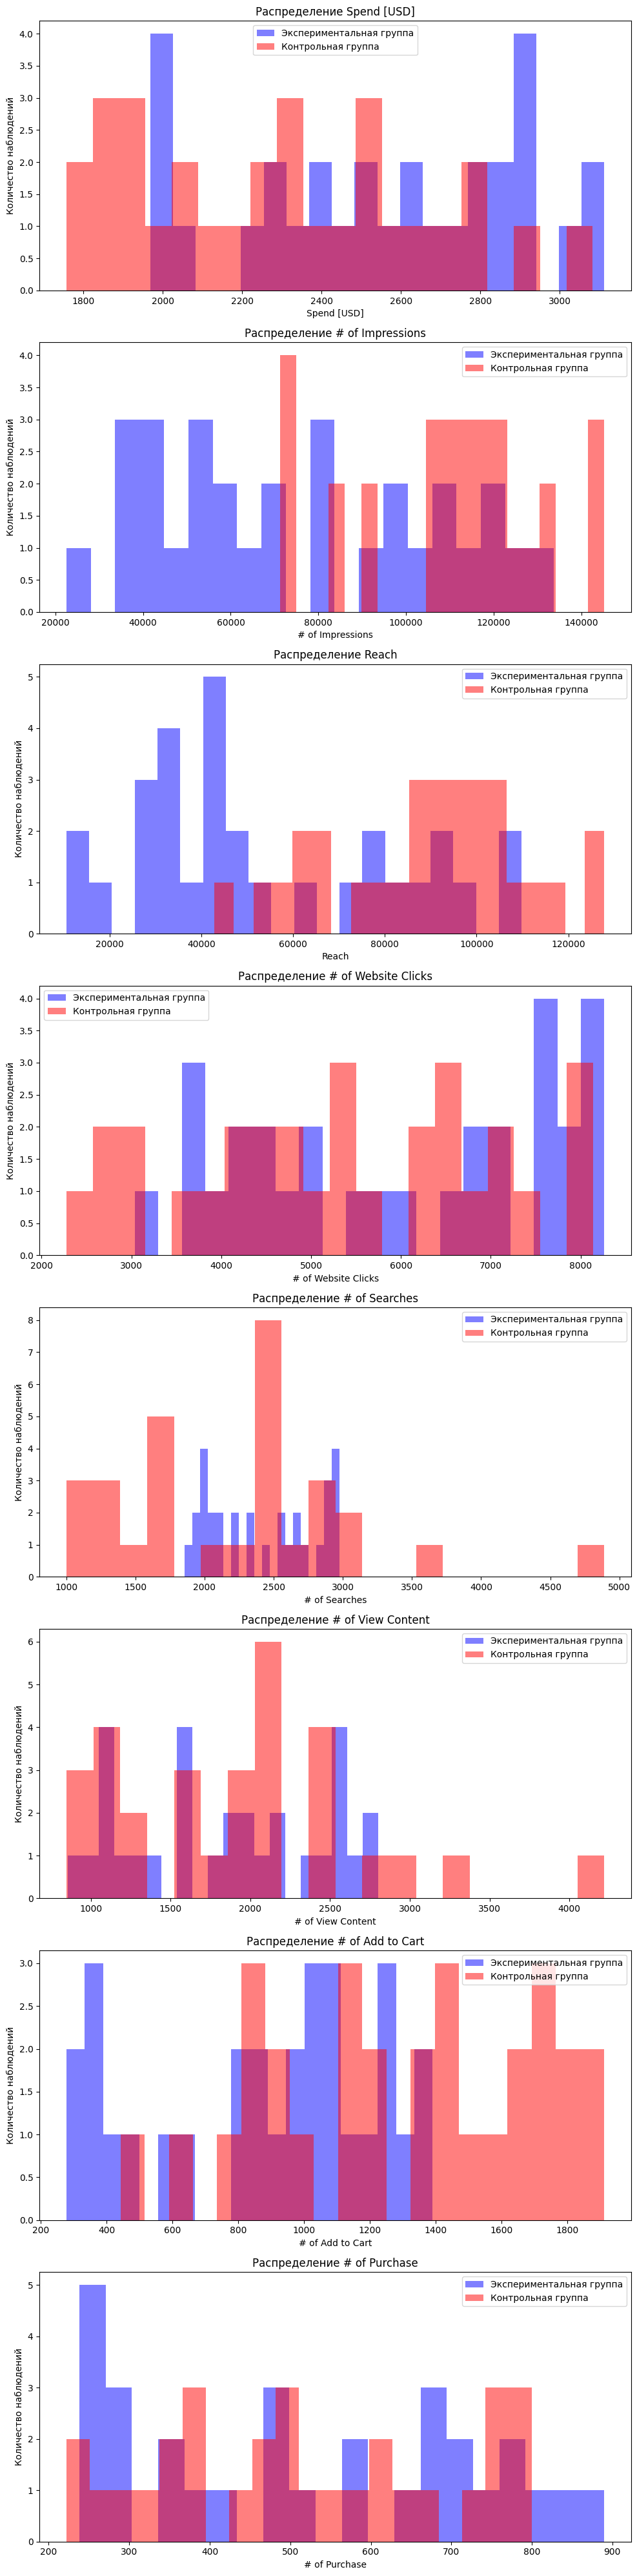

In [39]:
fig, axes = plt.subplots(nrows=len(metrics), ncols=1, figsize=(10, 5 * len(metrics)))

for i, metric in enumerate(metrics):
    ax = axes[i]
    ax.hist(test_group_data[metric], bins=20, alpha=0.5, label='Экспериментальная группа', color='blue')
    ax.hist(control_group_data[metric], bins=20, alpha=0.5, label='Контрольная группа', color='red')
    ax.set_title(f'Распределение {metric}')
    ax.set_xlabel(metric)
    ax.set_ylabel('Количество наблюдений')
    ax.legend()

plt.tight_layout()
plt.show()


Исходя из результатов тестов, мы видим, что изменение модели расчета ставки в рекламной кампании (эксперимент) оказывает статистически значимое влияние на некоторые метрики, такие как расходы на рекламу, количество просмотров и уникальные пользователи. Однако, эти изменения не сказываются на количестве посещений сайта, количестве поисковых запросов, просмотре деталей товара и количестве покупок.

Сделаем A/A тест для оценки параметров и проверки репрезентативности и однородности выборок.

In [43]:
for metric in metrics:
    metric_data = test_group_data[metric]

    sample1 = metric_data
    sample2 = metric_data

    t_statistic, p_value = stats.ttest_ind(sample1, sample2)

    alpha = 0.05
    if p_value < alpha:
        print(f'Метрика: {metric} - Различия статистически значимы')
    else:
        print(f'Метрика: {metric} - Нет статистически значимых различий')


Метрика: Spend [USD] - Нет статистически значимых различий
Метрика: # of Impressions - Нет статистически значимых различий
Метрика: Reach - Нет статистически значимых различий
Метрика: # of Website Clicks - Нет статистически значимых различий
Метрика: # of Searches - Нет статистически значимых различий
Метрика: # of View Content - Нет статистически значимых различий
Метрика: # of Add to Cart - Нет статистически значимых различий
Метрика: # of Purchase - Нет статистически значимых различий


Мы видим, что среди метрик нет значимых различий, поэтому выборки однородны.

In [44]:
def run_t_test(exp_group, control_group, alpha=0.05):
    t_statistic, p_value = stats.ttest_ind(exp_group, control_group)
    result = {
        'T-статистика': t_statistic,
        'p-value': p_value
    }
    if p_value < alpha:
        result['Статистические различия'] = 'Да'
    else:
        result['Статистические различия'] = 'Нет'
    return result

results = pd.DataFrame(columns=['Метрика', 'T-статистика', 'p-value', 'Статистические различия'])

for metric in metrics:
    exp_group = test_group_data[metric]
    control_group = control_group_data[metric]

    result = run_t_test(exp_group, control_group)
    result['Метрика'] = metric
    results = results.append(result, ignore_index=True)

print(results)


               Метрика  T-статистика   p-value Статистические различия
0          Spend [USD]      2.969992  0.004326                      Да
1     # of Impressions     -4.986992  0.000006                      Да
2                Reach     -5.405946  0.000001                      Да
3  # of Website Clicks      1.611568  0.112485                     Нет
4        # of Searches      1.123589  0.265817                     Нет
5    # of View Content     -0.491990  0.624584                     Нет
6     # of Add to Cart     -4.336005  0.000059                      Да
7        # of Purchase     -0.016384  0.986984                     Нет


<ipython-input-44-ac595fe40121>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(result, ignore_index=True)
<ipython-input-44-ac595fe40121>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(result, ignore_index=True)
<ipython-input-44-ac595fe40121>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(result, ignore_index=True)
<ipython-input-44-ac595fe40121>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(result, ignore_index=True)
<ipython-input-44-ac595fe40121>:24: FutureWarning: The frame.append method is deprecated and will be removed

Для оценки статистической значимости исходя из предоставленных результатов, мы рассмотрим каждую метрику по отдельности:

1. **Spend [USD]**:
   - T-статистика: 2.969992
   - p-value: 0.004326
   - Статистические различия: Да
   - Ошибка первого рода: 0.004326 (4.33%)

2. **# of Impressions**:
   - T-статистика: -4.986992
   - p-value: 0.000006
   - Статистические различия: Да
   - Ошибка первого рода: 0.000006 (0.0006%)

3. **Reach**:
   - T-статистика: -5.405946
   - p-value: 0.000001
   - Статистические различия: Да
   - Ошибка первого рода: 0.000001 (0.0001%)

4. **# of Website Clicks**:
   - T-статистика: 1.611568
   - p-value: 0.112485
   - Статистические различия: Нет
   - Ошибка первого рода: 0.112485 (11.25%)

5. **# of Searches**:
   - T-статистика: 1.123589
   - p-value: 0.265817
   - Статистические различия: Нет
   - Ошибка первого рода: 0.265817 (26.58%)

6. **# of View Content**:
   - T-статистика: -0.491990
   - p-value: 0.624584
   - Статистические различия: Нет
   - Ошибка первого рода: 0.624584 (62.46%)

7. **# of Add to Cart**:
   - T-статистика: -4.336005
   - p-value: 0.000059
   - Статистические различия: Да
   - Ошибка первого рода: 0.000059 (0.0059%)

8. **# of Purchase**:
   - T-статистика: -0.016384
   - p-value: 0.986984
   - Статистические различия: Нет
   - Ошибка первого рода: 0.986984 (98.70%)
